## step1: import libraries

In [33]:
# step 1: import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    RocCurveDisplay,
)
from sklearn.pipeline import Pipeline                  # normal preprocessing pipeline
from sklearn.model_selection import train_test_split  
from sklearn.utils.class_weight import compute_class_weight # ⬅ ADD THIS

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # SMOTE + model pipeline

## step2: load dataset

In [34]:
df = pd.read_csv(r"C:\Users\rohan\Desktop\Minor Project\DATASET\framingham.csv")  
# remove rows with missing values (simple approach)
df = df.dropna()
print(df.shape)
df.head()

(3658, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Step 3: Split features and target

In [35]:
X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"]

## Step 4: Split train–test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Step 5: Preprocessing Pipeline

In [37]:
num_features = X_train.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features)
    ]
)

## Step 6: Logistic Regression Model

In [38]:
log_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=500))
])

log_clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Step 7: Evaluate Model (logistic Regression)

In [39]:
pred_probs = log_clf.predict_proba(X_test)[:,1]
pred_labels = (pred_probs > 0.5).astype(int)

print("Accuracy =", accuracy_score(y_test, pred_labels))
print("AUC =", roc_auc_score(y_test, pred_probs))
print(classification_report(y_test, pred_labels))

Accuracy = 0.8620218579234973
AUC = 0.7257112184648418
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       621
           1       0.73      0.14      0.24       111

    accuracy                           0.86       732
   macro avg       0.80      0.57      0.58       732
weighted avg       0.85      0.86      0.82       732



## step 8: Calculate scale_pos_weight

In [40]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

## Step 9: XGBoost model training 

In [41]:
# pos_weight = weight of minority class
pos_weight = class_weights[1] / class_weights[0]
print("scale_pos_weight =", pos_weight)

# -------------------------
# STEP 3: XGBoost model
# -------------------------
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    random_state=42,
)

model.fit(X_train, y_train)#

scale_pos_weight = 5.560538116591928


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Step 10: Evaluation

In [42]:
preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy: 0.7773224043715847
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       621
           1       0.28      0.29      0.28       111

    accuracy                           0.78       732
   macro avg       0.57      0.58      0.58       732
weighted avg       0.78      0.78      0.78       732



## step 11: save the model

In [43]:
import joblib
joblib.dump(model, "heart_xgb_model.pkl")

print("Model saved as heart_xgb_model.pkl")

Model saved as heart_xgb_model.pkl


## Step 12: load the model

In [44]:
import joblib

loaded_model = joblib.load("heart_xgb_model.pkl")
print("Model loaded!")

Model loaded!


In [45]:
example_patient = {
    'age': 61,
    'sex': 0,
    'currentSmoker': 1,
    'cigsPerDay': 30,
    'BPMeds': 0,
    'prevalentStroke': 0,
    'prevalentHyp': 0,
    'diabetes': 0,
    'totChol': 225,
    'sysBP': 150,
    'diaBP': 95,
    'BMI': 28.58,
    'heartRate': 65,
    'glucose': 103,
    'education': 3,
    'male': 0
}

patient_df = pd.DataFrame([example_patient])


In [46]:
# Ensure column order matches training
patient_df = patient_df[loaded_model.feature_names_in_]

# Predict
prob = loaded_model.predict_proba(patient_df)[:,1][0]

risk_label = "High" if prob > 0.5 else "Low"
survival_prob = 1 - prob
survival_years = survival_prob * 10
survival_days = survival_years * 365

print(f"Probability of Heart Attack: {prob*100:.2f}%")
print(f"Risk Level: {risk_label}")
print(f"Probability of Survival: {survival_prob*100:.2f}%")
print(f"Estimated Survival Time: {survival_years:.2f} years")
print(f"Estimated Survival Time: {survival_days:.0f} days")

Probability of Heart Attack: 43.91%
Risk Level: Low
Probability of Survival: 56.09%
Estimated Survival Time: 5.61 years
Estimated Survival Time: 2047 days



Training a simple Decision Tree for visualization...


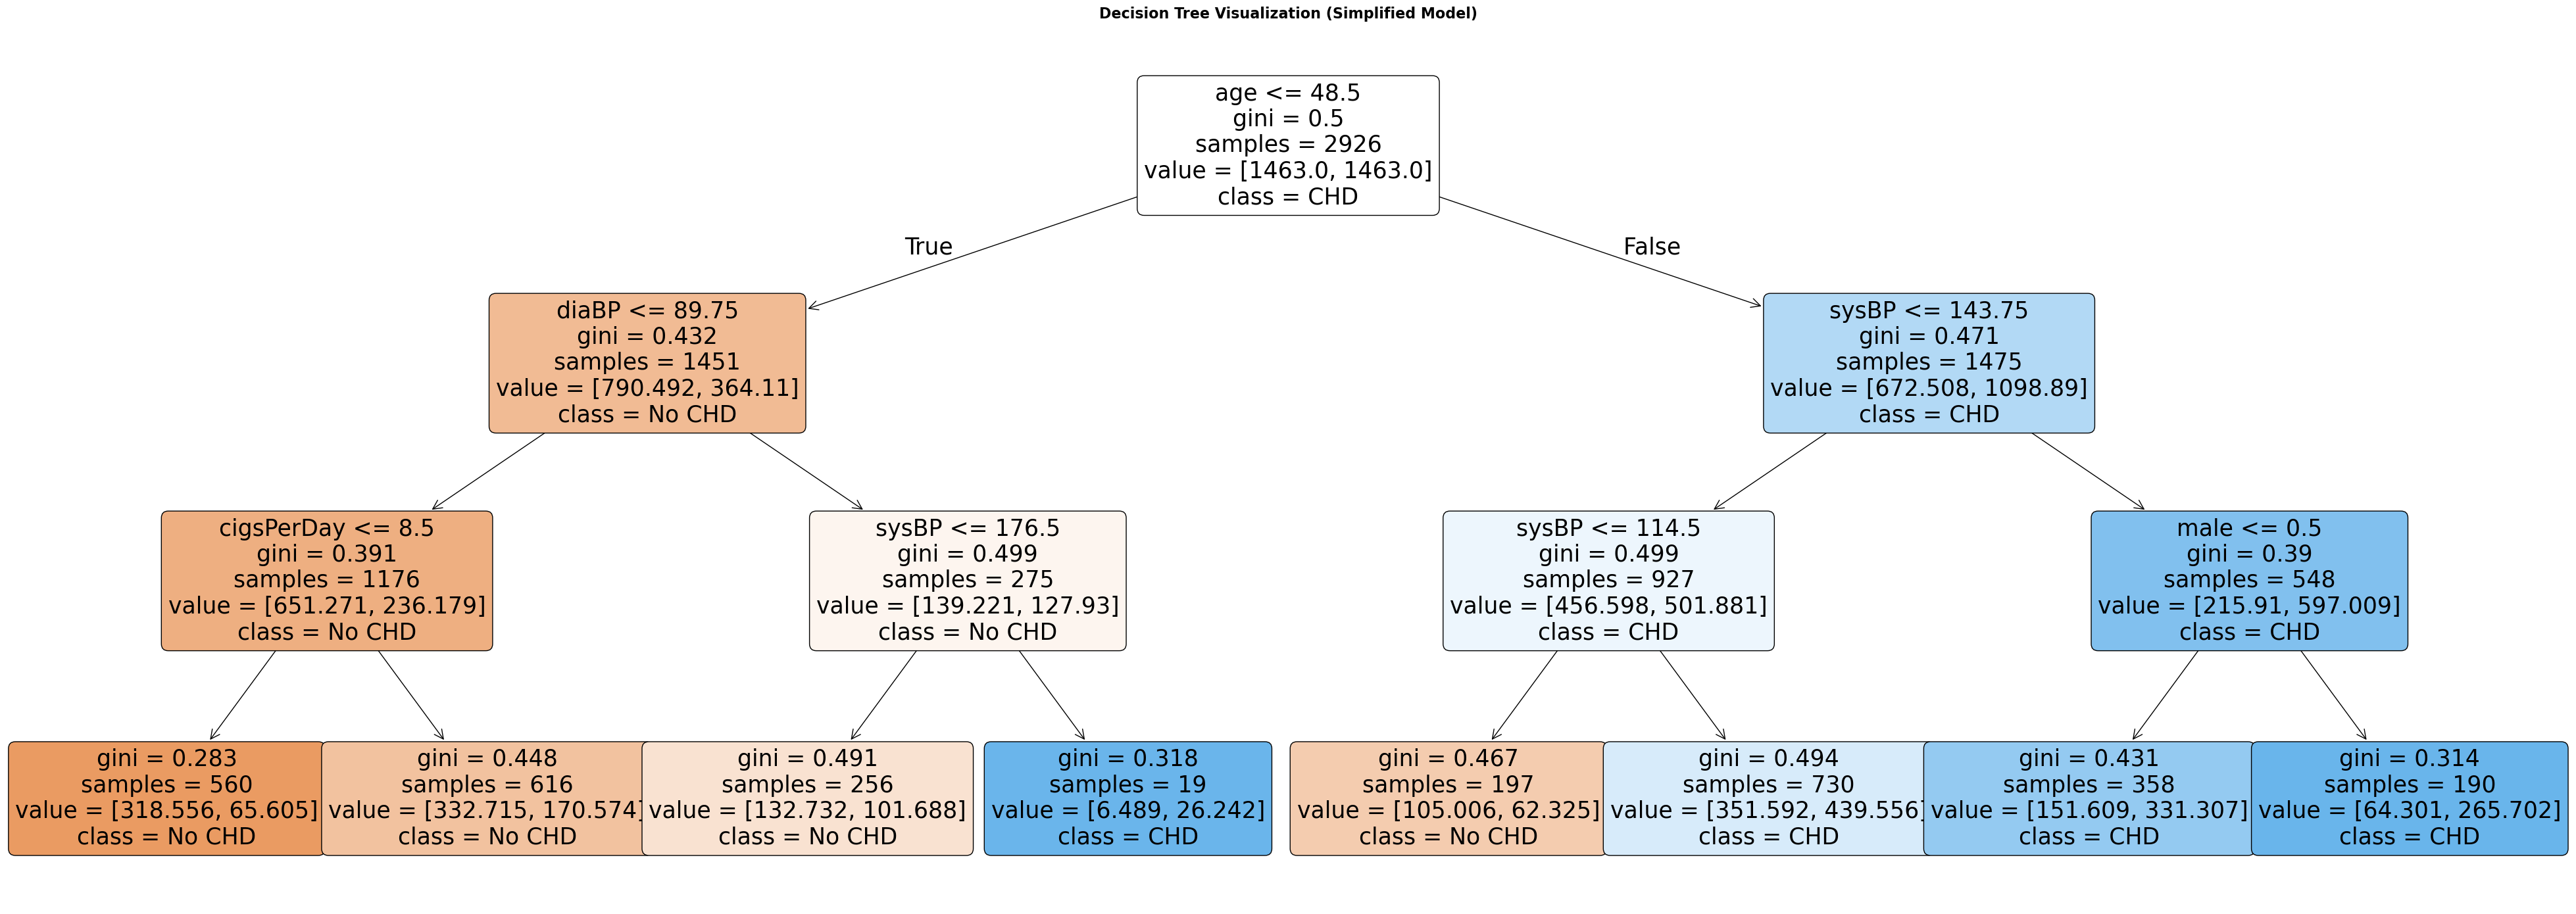

In [47]:
print("\nTraining a simple Decision Tree for visualization...")

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


# Train a simpler decision tree for visualization (XGBoost trees are too complex)
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42, 
                                   class_weight='balanced')
dt_model.fit(X_train, y_train)

plt.figure(figsize=(40, 14))
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=['No CHD', 'CHD'],
          filled=True, 
          rounded=True,
          fontsize=25)
plt.title('Decision Tree Visualization (Simplified Model)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('9_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()
